In [1]:
import cv2
import torch
import time
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import torch.nn as nn
import torchvision.models as models


In [2]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

csrnet = CSRNet().to(device)
ckpt = torch.load("finetuned_epoch_29.pth", map_location=device)
csrnet.load_state_dict(ckpt["model"])
csrnet.eval()

print("✅ CSRNet loaded on:", device)


d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ CSRNet loaded on: cpu


In [4]:
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (1024, 768))
    frame_resized = frame_resized / 255.0
    frame_resized = frame_resized.transpose(2, 0, 1)
    tensor = torch.tensor(frame_resized, dtype=torch.float32).unsqueeze(0).to(device)
    return tensor


In [5]:
def csrnet_count(frame):
    inp = preprocess_frame(frame)

    with torch.no_grad():
        density_map = csrnet(inp).cpu().numpy()[0, 0]

    count = density_map.sum()

    # Normalize density map for visualization
    heatmap = density_map / density_map.max()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

    alert = "SAFE"
    color = (0, 255, 0)
    if count > 100:
        alert = "⚠️ CROWD ALERT"
        color = (0, 0, 255)

    cv2.putText(
        overlay,
        f"Count: {count:.1f} | {alert}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        color,
        3
    )

    return overlay, count, alert


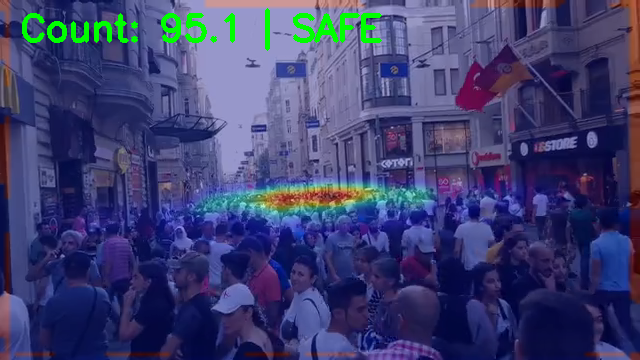

🎞 Frame: 275/275
📊 Progress: 100.0%
👥 Count: 95.1 | SAFE
⏳ Elapsed: 1553.4s
⏱ ETA: 0.0s
✅ Video processing complete
📁 Output saved as: csrnet_only_output.mp4


In [6]:
VIDEO_PATH = "test1.mp4"
OUTPUT_PATH = "csrnet_only_output.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (w, h))

frame_id = 0
start_time = time.time()

print("🎥 Processing video with CSRNet ONLY...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    processed, count, alert = csrnet_count(frame)
    out.write(processed)

    frame_id += 1

    if frame_id % 5 == 0:
        elapsed = time.time() - start_time
        avg = elapsed / frame_id
        remaining = (total_frames - frame_id) * avg
        progress = (frame_id / total_frames) * 100

        rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        display(Image.fromarray(rgb))

        print(f"🎞 Frame: {frame_id}/{total_frames}")
        print(f"📊 Progress: {progress:.1f}%")
        print(f"👥 Count: {count:.1f} | {alert}")
        print(f"⏳ Elapsed: {elapsed:.1f}s")
        print(f"⏱ ETA: {remaining:.1f}s")

cap.release()
out.release()

print("✅ Video processing complete")
print("📁 Output saved as:", OUTPUT_PATH)
